Medway - Local Election Results - 2023
======================================

In [25]:
%matplotlib inline
import requests
import pandas as pd

# from glob import glob
import re
import geopandas as gpd

from matplotlib import pyplot as plt
import contextily as cx

import seaborn as sns

from IPython.display import display, HTML

### TODO

[ ] Rejection reasons - add to df_ward  

### 0. Config

In [2]:
# Paths
path_data = 'data'

# Medway Council - Local Election Results 2023 website
url_results = "https://www.medway.gov.uk/results2023"

In [3]:
# Ward seats
ward_seats = {
    "All Saints": 1,
    "Chatham Central and Brompton": 3,
    "Cuxton, Halling and Riverside": 2,
    "Fort Horsted": 1,
    "Fort Pitt": 3,
    "Gillingham North": 3,
    "Gillingham South": 3,
    "Hempstead and Wigmore": 2,
    "Hoo St Werburgh and High Halstow": 3,
    "Lordswood and Walderslade": 3,
    "Luton": 2,
    "Princes Park": 2,
    "Rainham North": 3,
    "Rainham South East": 3,
    "Rainham South West": 2,
    "Rochester East and Warren Wood": 3,
    "Rochester West and Borstal": 3,
    "St Mary's Island": 1,
    "Strood North and Frindsbury": 3,
    "Strood Rural": 3,
    "Strood West": 3,
    "Twydall": 2,
    "Watling": 3,
    "Wayfield and Weeds Wood": 2
 }
assert sum([x for x in ward_seats.values()]) == 59

In [4]:
# Party map
map_party = {
       "Conservative Party candidate": "Conservative",
       "Labour and Co-operative Party": "Labour",
       "Labour Party": "Labour",
       "Local Conservatives": "Conservative",
}

In [5]:
# Colours map
x = sns.color_palette("Paired")
print(x.as_hex())
display(x)

map_colors = {
       "Christian Peoples Alliance": "#ffff99",
       "Conservative Party candidate": "#1f78b4",
       "Conservative": "#1f78b4",
       "Green Party": "#33a021",
       "Heritage Party": "#fdbf6f",
       "Independent": "#ff7f00",
       "Labour and Co-operative Party": "#fb9a99",
       "Labour Party": "#e31a1c",
        "Labour": "#e31a1c",
       "Liberal Democrats": "#cab2d6",
       "Local Conservatives": "#a6cee3",
       "Reform UK": "#b15928",
       "Social Democratic Party": "#6a3d9a"
}



['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#b15928']


[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

### 1. Load Data

In [10]:
### 1. Load data
df_wards = pd.read_csv('data/wards.csv')
df_results = pd.read_csv('data/results.csv')

### 2. Analysis

Seats: 1


,Unnamed: 0,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
5,5,Spalding,Christopher Stuart (commonly known as Chris Sp...,Independent,295,All Saints,https://www.medway.gov.uk/info/200670/local_an...,Chris Spalding,Spalding,Independent
6,6,Wallace,Julie,Independent,252,All Saints,https://www.medway.gov.uk/info/200670/local_an...,Julie,Wallace,Independent
3,3,Ogunfemi,Habeeb Adeyemi (commonly known as Harold Ogunf...,Local Conservatives,190,All Saints,https://www.medway.gov.uk/info/200670/local_an...,Harold Ogunfemi,Ogunfemi,Conservative
1,1,Kemp,Kier Dorran,Labour Party,118,All Saints,https://www.medway.gov.uk/info/200670/local_an...,Kier Dorran,Kemp,Labour
2,2,Khatkar,Harjinder Singh (commonly known as Bill Khatkar),Reform UK,49,All Saints,https://www.medway.gov.uk/info/200670/local_an...,Bill Khatkar,Khatkar,Reform UK
0,0,Hyde,Bernard Edward,Green Party,34,All Saints,https://www.medway.gov.uk/info/200670/local_an...,Bernard Edward,Hyde,Green Party
4,4,Simpson,Elizabeth Ann,Liberal Democrats,22,All Saints,https://www.medway.gov.uk/info/200670/local_an...,Elizabeth Ann,Simpson,Liberal Democrats


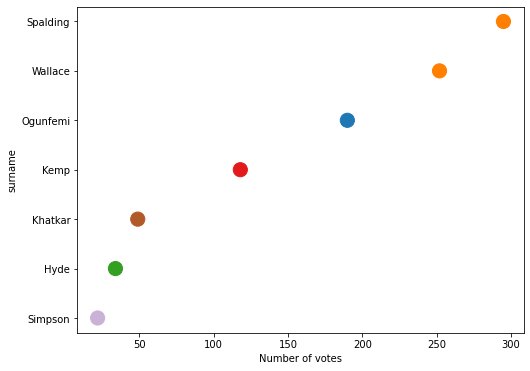

Seats: 3


,Unnamed: 0,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
12,5,Maple,Vincent Stewart (commonly known as Vince Maple),Labour and Co-operative Party,1394,Chatham Central and Brompton,https://www.medway.gov.uk/info/200670/local_an...,Vince Maple,Maple,Labour
8,1,Gurung,Nina,Labour and Co-operative Party,1211,Chatham Central and Brompton,https://www.medway.gov.uk/info/200670/local_an...,Nina,Gurung,Labour
7,0,Animashaun,Shakirat Oyindamola (Commonly known as Damola ...,Labour and Co-operative Party,1136,Chatham Central and Brompton,https://www.medway.gov.uk/info/200670/local_an...,Damola Animashaun,Animashaun,Labour
10,3,Khera,Vrinderpal Singh (commonly known as Paul Khera),Local Conservatives,552,Chatham Central and Brompton,https://www.medway.gov.uk/info/200670/local_an...,Paul Khera,Khera,Conservative
11,4,King,Claude Jenner Granville,Local Conservatives,517,Chatham Central and Brompton,https://www.medway.gov.uk/info/200670/local_an...,Claude Jenner Granville,King,Conservative
14,7,Tejan,Habib Odunlamin,Local Conservatives,467,Chatham Central and Brompton,https://www.medway.gov.uk/info/200670/local_an...,Habib Odunlamin,Tejan,Conservative
13,6,O'Hanlon,Robert Gerald Edward (commonly known as Rob O'...,Green Party,336,Chatham Central and Brompton,https://www.medway.gov.uk/info/200670/local_an...,Rob O'Hanlon,O'Hanlon,Green Party
9,2,Juby,Geoffrey William (commonly known as Geoff Juby),Liberal Democrats,295,Chatham Central and Brompton,https://www.medway.gov.uk/info/200670/local_an...,Geoff Juby,Juby,Liberal Democrats


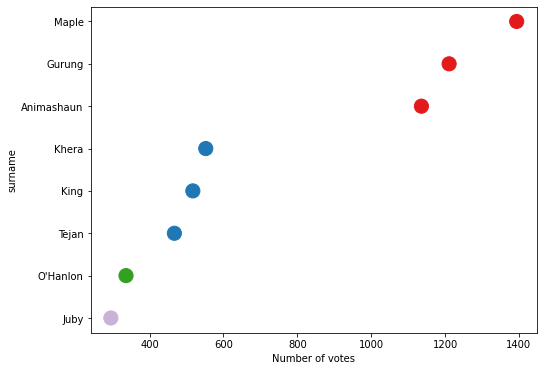

Seats: 2


,Unnamed: 0,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
15,0,Fearn,Matthew James (commonly known as Matt Fearn),Local Conservatives,880,"Cuxton, Halling and Riverside",https://www.medway.gov.uk/info/200670/local_an...,Matt Fearn,Fearn,Conservative
16,1,Filmer,Phillip (commonly known as Phil Filmer),Local Conservatives,685,"Cuxton, Halling and Riverside",https://www.medway.gov.uk/info/200670/local_an...,Phil Filmer,Filmer,Conservative
21,6,Nightingale,Matthew Richard (commonly known as Matt Nighti...,Green Party,641,"Cuxton, Halling and Riverside",https://www.medway.gov.uk/info/200670/local_an...,Matt Nightingale,Nightingale,Green Party
18,3,Jamieson,Catriona Margaret (commonly known as Cat Jamie...,Green Party,502,"Cuxton, Halling and Riverside",https://www.medway.gov.uk/info/200670/local_an...,Cat Jamieson,Jamieson,Green Party
19,4,McCormack,Stephen Joseph Donald,Labour Party,414,"Cuxton, Halling and Riverside",https://www.medway.gov.uk/info/200670/local_an...,Stephen Joseph Donald,McCormack,Labour
20,5,Morris,Victoria Valerie,Labour Party,408,"Cuxton, Halling and Riverside",https://www.medway.gov.uk/info/200670/local_an...,Victoria Valerie,Morris,Labour
17,2,Gillett,Ronald Arcon (commonly known as Ron Gillett),Liberal Democrats,76,"Cuxton, Halling and Riverside",https://www.medway.gov.uk/info/200670/local_an...,Ron Gillett,Gillett,Liberal Democrats


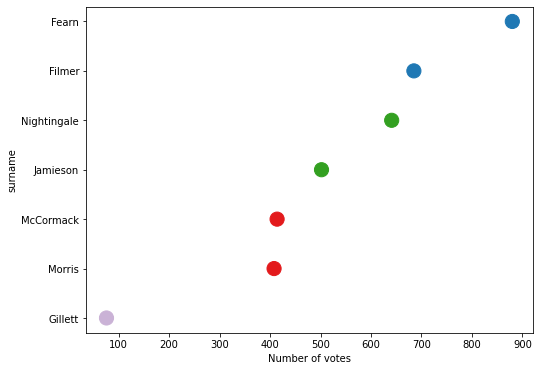

Seats: 1


,Unnamed: 0,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
22,0,Clarke,Trevor Anthony,Local Conservatives,489,Fort Horsted,https://www.medway.gov.uk/info/200670/local_an...,Trevor Anthony,Clarke,Conservative
25,3,Parker,Vivienne (commonly known as Viv Parker),Liberal Democrats,344,Fort Horsted,https://www.medway.gov.uk/info/200670/local_an...,Viv Parker,Parker,Liberal Democrats
24,2,Murray,Joseph Simon,Labour Party,212,Fort Horsted,https://www.medway.gov.uk/info/200670/local_an...,Joseph Simon,Murray,Labour
23,1,Knott,Matthews John,Green Party,37,Fort Horsted,https://www.medway.gov.uk/info/200670/local_an...,Matthews John,Knott,Green Party


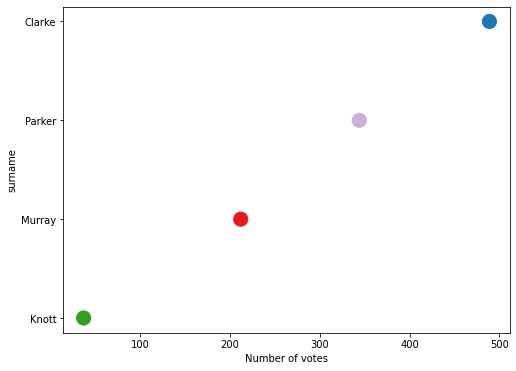

Seats: 3


,Unnamed: 0,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
26,0,Campbell,Smitha,Labour and Co-operative Party,1726,Fort Pitt,https://www.medway.gov.uk/info/200670/local_an...,Smitha,Campbell,Labour
27,1,Mahil,Harinder Singh,Labour and Co-operative Party,1634,Fort Pitt,https://www.medway.gov.uk/info/200670/local_an...,Harinder Singh,Mahil,Labour
28,2,Myton,Richard Gareth,Labour and Co-operative Party,1577,Fort Pitt,https://www.medway.gov.uk/info/200670/local_an...,Richard Gareth,Myton,Labour
33,7,Turpin,Rupert David Fearon,Local Conservatives,1028,Fort Pitt,https://www.medway.gov.uk/info/200670/local_an...,Rupert David Fearon,Turpin,Conservative
32,6,Thorne,Richard Niall,Local Conservatives,951,Fort Pitt,https://www.medway.gov.uk/info/200670/local_an...,Richard Niall,Thorne,Conservative
29,3,Opara,Gloria Blessing Chukwuka,Local Conservatives,901,Fort Pitt,https://www.medway.gov.uk/info/200670/local_an...,Gloria Blessing Chukwuka,Opara,Conservative
31,5,Scott,Karen,Green Party,527,Fort Pitt,https://www.medway.gov.uk/info/200670/local_an...,Karen,Scott,Green Party
30,4,Sandhu,Nirmal,Liberal Democrats,249,Fort Pitt,https://www.medway.gov.uk/info/200670/local_an...,Nirmal,Sandhu,Liberal Democrats


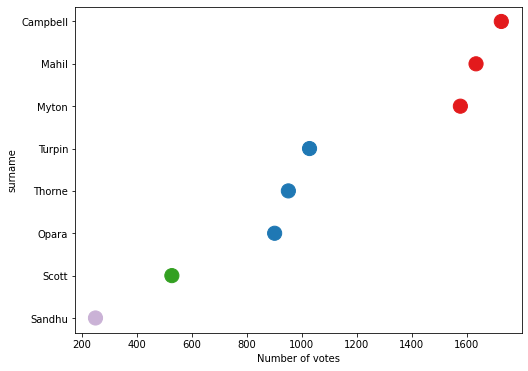

Seats: 3


,Unnamed: 0,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
38,4,Price,Adam Robert William,Labour and Co-operative Party,1419,Gillingham North,https://www.medway.gov.uk/info/200670/local_an...,Adam Robert William,Price,Labour
36,2,Hamandishe,Douglas Kudakwashe,Labour and Co-operative Party,1355,Gillingham North,https://www.medway.gov.uk/info/200670/local_an...,Douglas Kudakwashe,Hamandishe,Labour
37,3,Mandaracas,Lia Helen,Labour and Co-operative Party,1339,Gillingham North,https://www.medway.gov.uk/info/200670/local_an...,Lia Helen,Mandaracas,Labour
34,0,Barrett,Clayton,Conservative Party candidate,530,Gillingham North,https://www.medway.gov.uk/info/200670/local_an...,Clayton,Barrett,Conservative
35,1,Chishti,Zarina Bibi,Conservative Party candidate,439,Gillingham North,https://www.medway.gov.uk/info/200670/local_an...,Zarina Bibi,Chishti,Conservative
40,6,Sidhu,Harbans Singh,Conservative Party candidate,410,Gillingham North,https://www.medway.gov.uk/info/200670/local_an...,Harbans Singh,Sidhu,Conservative
41,7,Spyby-Steanson,Jeremy,Green Party,340,Gillingham North,https://www.medway.gov.uk/info/200670/local_an...,Jeremy,Spyby-Steanson,Green Party
39,5,Rist,Ben Darryl,Liberal Democrats,254,Gillingham North,https://www.medway.gov.uk/info/200670/local_an...,Ben Darryl,Rist,Liberal Democrats


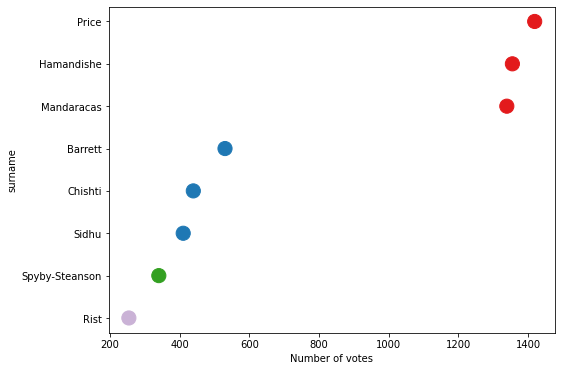

Seats: 3


,Unnamed: 0,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
46,4,McDonald,Rory Craig (commonly known as Dan McDonald),Labour and Co-operative Party,1617,Gillingham South,https://www.medway.gov.uk/info/200670/local_an...,Dan McDonald,McDonald,Labour
45,3,Khan,Naushabah Parveen,Labour and Co-operative Party,1531,Gillingham South,https://www.medway.gov.uk/info/200670/local_an...,Naushabah Parveen,Khan,Labour
47,5,Prenter,Louwella Margaret,Labour and Co-operative Party,1491,Gillingham South,https://www.medway.gov.uk/info/200670/local_an...,Louwella Margaret,Prenter,Labour
49,7,Smith,Amy,Conservative Party candidate,509,Gillingham South,https://www.medway.gov.uk/info/200670/local_an...,Amy,Smith,Conservative
42,0,Adeoye,Sijuwade Adenike (commonly known as Siju Adeoye),Conservative Party candidate,471,Gillingham South,https://www.medway.gov.uk/info/200670/local_an...,Siju Adeoye,Adeoye,Conservative
43,1,Belmonte,Daniel Luis,Green Party,373,Gillingham South,https://www.medway.gov.uk/info/200670/local_an...,Daniel Luis,Belmonte,Green Party
44,2,Georghiou,George,Conservative Party candidate,373,Gillingham South,https://www.medway.gov.uk/info/200670/local_an...,George,Georghiou,Conservative
48,6,Sams,Christopher John,Liberal Democrats,322,Gillingham South,https://www.medway.gov.uk/info/200670/local_an...,Christopher John,Sams,Liberal Democrats


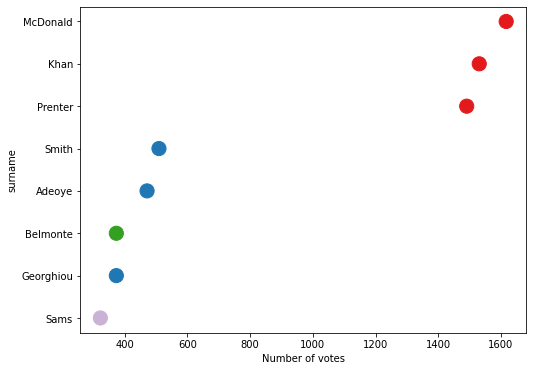

Seats: 2


,Unnamed: 0,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
52,2,Gilbourne,James Adrian (commonly known as Jim Gilbourne),Conservative Party candidate,1709,Hempstead and Wigmore,https://www.medway.gov.uk/info/200670/local_an...,Jim Gilbourne,Gilbourne,Conservative
56,6,Lawrence,Andrew William John,Conservative Party candidate,1617,Hempstead and Wigmore,https://www.medway.gov.uk/info/200670/local_an...,Andrew William John,Lawrence,Conservative
50,0,Bailey,Lewis John William,Labour Party,603,Hempstead and Wigmore,https://www.medway.gov.uk/info/200670/local_an...,Lewis John William,Bailey,Labour
54,4,Kahn,Haroon Ali,Labour Party,450,Hempstead and Wigmore,https://www.medway.gov.uk/info/200670/local_an...,Haroon Ali,Kahn,Labour
55,5,Korff,Kathryn Amanda (commonly known as Kat Korff),Green Party,237,Hempstead and Wigmore,https://www.medway.gov.uk/info/200670/local_an...,Kat Korff,Korff,Green Party
51,1,Cavaliere,Daniele Erico Sergio (commonly known as Daniel...,Liberal Democrats,222,Hempstead and Wigmore,https://www.medway.gov.uk/info/200670/local_an...,Daniel Cavaliere,Cavaliere,Liberal Democrats
57,7,Wheeler,Peter Anthony,Social Democratic Party,58,Hempstead and Wigmore,https://www.medway.gov.uk/info/200670/local_an...,Peter Anthony,Wheeler,Social Democratic Party
53,3,Gibson,John Wesley,Christian Peoples Alliance,50,Hempstead and Wigmore,https://www.medway.gov.uk/info/200670/local_an...,John Wesley,Gibson,Christian Peoples Alliance


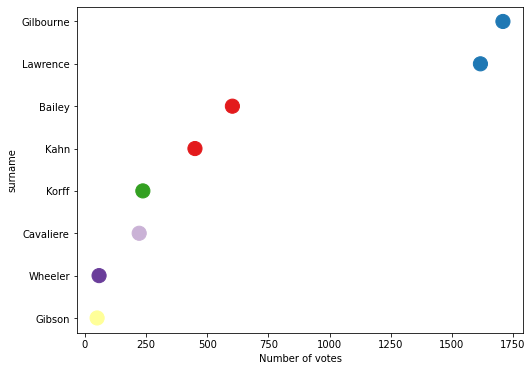

Seats: 3


,Unnamed: 0,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
60,2,Crozer,George Josiah Thomas,Independent,2388,Hoo St Werburgh and High Halstow,https://www.medway.gov.uk/info/200670/local_an...,George Josiah Thomas,Crozer,Independent
64,6,Sands,Ronald Philip (commonly known as Ron Sands),Independent,2279,Hoo St Werburgh and High Halstow,https://www.medway.gov.uk/info/200670/local_an...,Ron Sands,Sands,Independent
63,5,Pearce,Michael Ian,Independent,2230,Hoo St Werburgh and High Halstow,https://www.medway.gov.uk/info/200670/local_an...,Michael Ian,Pearce,Independent
68,10,Tildesley,Robert John,Local Conservatives,465,Hoo St Werburgh and High Halstow,https://www.medway.gov.uk/info/200670/local_an...,Robert John,Tildesley,Conservative
66,8,Sparks,Christopher John (commonly known as Chris Sparks),Local Conservatives,427,Hoo St Werburgh and High Halstow,https://www.medway.gov.uk/info/200670/local_an...,Chris Sparks,Sparks,Conservative
62,4,Mitchell,Fatima,Local Conservatives,409,Hoo St Werburgh and High Halstow,https://www.medway.gov.uk/info/200670/local_an...,Fatima,Mitchell,Conservative
58,0,Barwell,Gary,Labour Party,358,Hoo St Werburgh and High Halstow,https://www.medway.gov.uk/info/200670/local_an...,Gary,Barwell,Labour
59,1,Christmas,Guiliana Paola,Labour Party,336,Hoo St Werburgh and High Halstow,https://www.medway.gov.uk/info/200670/local_an...,Guiliana Paola,Christmas,Labour
69,11,Vickery,Stephen Allan,Labour Party,286,Hoo St Werburgh and High Halstow,https://www.medway.gov.uk/info/200670/local_an...,Stephen Allan,Vickery,Labour
67,9,Sutton,Julian Charles,Green Party,140,Hoo St Werburgh and High Halstow,https://www.medway.gov.uk/info/200670/local_an...,Julian Charles,Sutton,Green Party


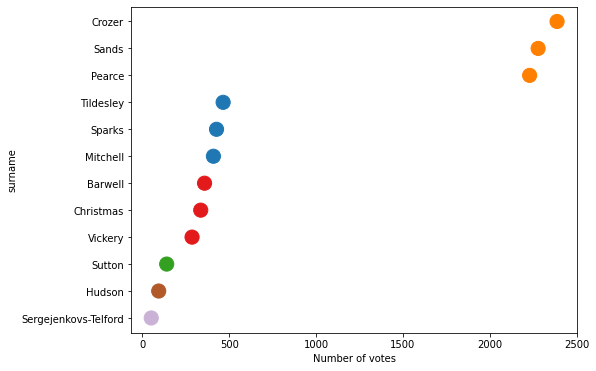

Seats: 3


,Unnamed: 0,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
71,1,Brake,David Frederick,Local Conservatives,1752,Lordswood and Walderslade,https://www.medway.gov.uk/info/200670/local_an...,David Frederick,Brake,Conservative
77,7,Wildey,David Robert,Local Conservatives,1728,Lordswood and Walderslade,https://www.medway.gov.uk/info/200670/local_an...,David Robert,Wildey,Conservative
74,4,Gulvin,Adrian Victor Henry,Local Conservatives,1618,Lordswood and Walderslade,https://www.medway.gov.uk/info/200670/local_an...,Adrian Victor Henry,Gulvin,Conservative
73,3,Godwin,Christine Janice,Labour Party,917,Lordswood and Walderslade,https://www.medway.gov.uk/info/200670/local_an...,Christine Janice,Godwin,Labour
70,0,Bowen,David Alun,Labour Party,817,Lordswood and Walderslade,https://www.medway.gov.uk/info/200670/local_an...,David Alun,Bowen,Labour
72,2,Cook,Bradley Charles George (commonly known as Brad...,Labour Party,777,Lordswood and Walderslade,https://www.medway.gov.uk/info/200670/local_an...,Brad Cook,Cook,Labour
75,5,Hyner,Sonia Lesley,Green Party,339,Lordswood and Walderslade,https://www.medway.gov.uk/info/200670/local_an...,Sonia Lesley,Hyner,Green Party
76,6,Vincent,Matthew William,Liberal Democrats,272,Lordswood and Walderslade,https://www.medway.gov.uk/info/200670/local_an...,Matthew William,Vincent,Liberal Democrats


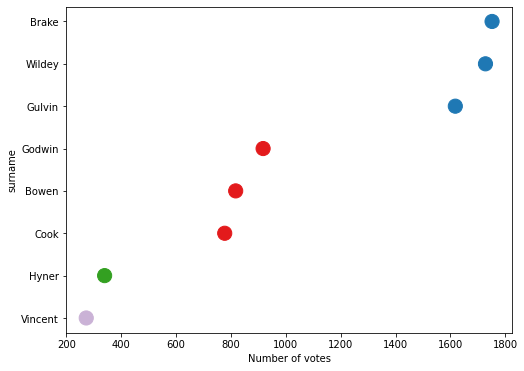

Seats: 2


,Unnamed: 0,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
78,0,Curry,Simon Michael,Labour and Co-operative Party,796,Luton,https://www.medway.gov.uk/info/200670/local_an...,Simon Michael,Curry,Labour
79,1,Howcroft-Scott,Joanne Christine (commonly known as Jo Howcrof...,Labour and Co-operative Party,751,Luton,https://www.medway.gov.uk/info/200670/local_an...,Jo Howcroft-Scott,Howcroft-Scott,Labour
81,3,Lammas,Marianna Hendrika (commonly known as Lulu Lammas),Conservative Party candidate,541,Luton,https://www.medway.gov.uk/info/200670/local_an...,Lulu Lammas,Lammas,Conservative
80,2,Igani,Mosueneme (commonly known as Mos Igani),Conservative Party candidate,510,Luton,https://www.medway.gov.uk/info/200670/local_an...,Mos Igani,Igani,Conservative
83,5,Sutton,Deborah Susan (commonly known as Debbie Sutton),Green Party,174,Luton,https://www.medway.gov.uk/info/200670/local_an...,Debbie Sutton,Sutton,Green Party
82,4,O'Neill,Paul Anthony,Liberal Democrats,136,Luton,https://www.medway.gov.uk/info/200670/local_an...,Paul Anthony,O'Neill,Liberal Democrats


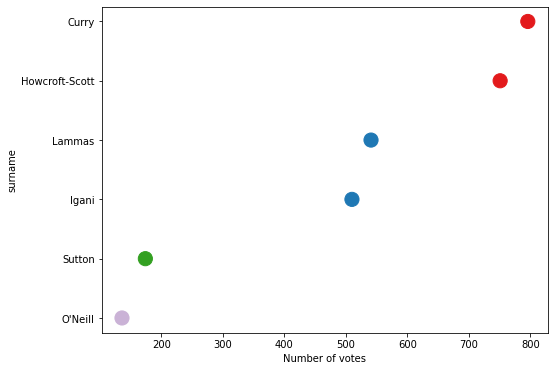

Seats: 2


,Unnamed: 0,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
85,1,Lammas,Robert George Benedict (commonly known as Robb...,Conservative Party candidate,938,Princes Park,https://www.medway.gov.uk/info/200670/local_an...,Robbie Lammas,Lammas,Conservative
84,0,Hyne,Alexander Thomas (commonly known as Alex),Conservative Party candidate,933,Princes Park,https://www.medway.gov.uk/info/200670/local_an...,Alex,Hyne,Conservative
89,5,Strevens,John Gower,Labour Party,486,Princes Park,https://www.medway.gov.uk/info/200670/local_an...,John Gower,Strevens,Labour
87,3,Olodo,Temitope Omontanwa (commonly known as Temi Olodo,Labour Party,425,Princes Park,https://www.medway.gov.uk/info/200670/local_an...,Temi Olodo,Olodo,Labour
86,2,Marchant,Simon Phillip,Green Party,156,Princes Park,https://www.medway.gov.uk/info/200670/local_an...,Simon Phillip,Marchant,Green Party
88,4,Sailes,Ian Christopher,Liberal Democrats,116,Princes Park,https://www.medway.gov.uk/info/200670/local_an...,Ian Christopher,Sailes,Liberal Democrats


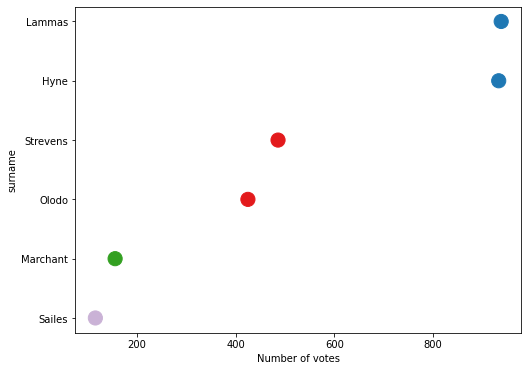

Seats: 3


,Unnamed: 0,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
98,8,Perfect,George Harry,Conservative Party candidate,1210,Rainham North,https://www.medway.gov.uk/info/200670/local_an...,George Harry,Perfect,Conservative
99,9,Spring,Wayne Ronald,Conservative Party candidate,1138,Rainham North,https://www.medway.gov.uk/info/200670/local_an...,Wayne Ronald,Spring,Conservative
90,0,Anang,Kwashie Amartei,Conservative Party candidate,1124,Rainham North,https://www.medway.gov.uk/info/200670/local_an...,Kwashie Amartei,Anang,Conservative
94,4,Harrison,Mark Richard,Labour Party,1025,Rainham North,https://www.medway.gov.uk/info/200670/local_an...,Mark Richard,Harrison,Labour
97,7,Morris,Nonchalonte Nikita (commonly known as Nikita M...,Labour Party,946,Rainham North,https://www.medway.gov.uk/info/200670/local_an...,Nikita Morris,Morris,Labour
95,5,Khan,Ahmed Mutahir (commonly known as Mutz Khan),Labour Party,907,Rainham North,https://www.medway.gov.uk/info/200670/local_an...,Mutz Khan,Khan,Labour
91,1,Bourne,Stuart James,Liberal Democrats,675,Rainham North,https://www.medway.gov.uk/info/200670/local_an...,Stuart James,Bourne,Liberal Democrats
96,6,Marchant,Patricia Anne (commonly known as Trish Marchant),Green Party,442,Rainham North,https://www.medway.gov.uk/info/200670/local_an...,Trish Marchant,Marchant,Green Party
93,3,Collins Rosell,Alan William,Liberal Democrats,402,Rainham North,https://www.medway.gov.uk/info/200670/local_an...,Alan William,Collins Rosell,Liberal Democrats
92,2,Chan,Yu Hin Nick (commonly known as Nicholas Chan),Liberal Democrats,323,Rainham North,https://www.medway.gov.uk/info/200670/local_an...,Nicholas Chan,Chan,Liberal Democrats


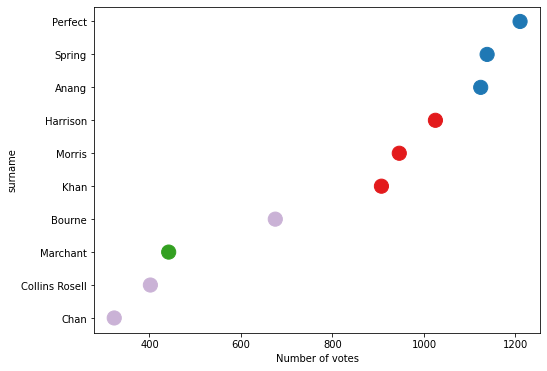

Seats: 3


,Unnamed: 0,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
100,0,Barrett,Roger,Conservative Party candidate,1455,Rainham South East,https://www.medway.gov.uk/info/200670/local_an...,Roger,Barrett,Conservative
103,3,Doe,Howard Francis,Conservative Party candidate,1448,Rainham South East,https://www.medway.gov.uk/info/200670/local_an...,Howard Francis,Doe,Conservative
104,4,Hackwell,Gary John,Conservative Party candidate,1430,Rainham South East,https://www.medway.gov.uk/info/200670/local_an...,Gary John,Hackwell,Conservative
101,1,Campbell,Katrina Karen,Labour Party,920,Rainham South East,https://www.medway.gov.uk/info/200670/local_an...,Katrina Karen,Campbell,Labour
102,2,Childs,Iain Michael,Labour Party,835,Rainham South East,https://www.medway.gov.uk/info/200670/local_an...,Iain Michael,Childs,Labour
106,6,Mottram,Chiron Peter,Labour Party,759,Rainham South East,https://www.medway.gov.uk/info/200670/local_an...,Chiron Peter,Mottram,Labour
108,8,Smith,Mary Winifred,Green Party,431,Rainham South East,https://www.medway.gov.uk/info/200670/local_an...,Mary Winifred,Smith,Green Party
105,5,Moore,Christopher Charles,Liberal Democrats,337,Rainham South East,https://www.medway.gov.uk/info/200670/local_an...,Christopher Charles,Moore,Liberal Democrats
107,7,Peacock,Roger James,Christian Peoples Alliance,158,Rainham South East,https://www.medway.gov.uk/info/200670/local_an...,Roger James,Peacock,Christian Peoples Alliance


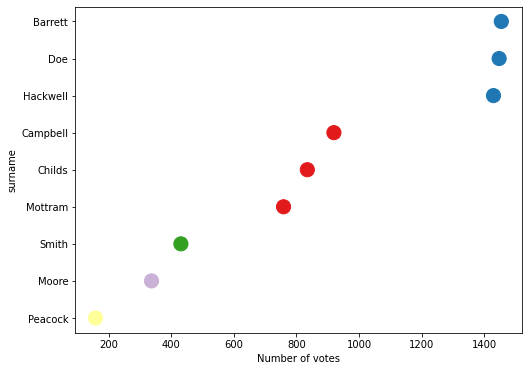

Seats: 2


,Unnamed: 0,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
114,5,Kemp,Barry Joseph,Conservative Party candidate,1177,Rainham South West,https://www.medway.gov.uk/info/200670/local_an...,Barry Joseph,Kemp,Conservative
113,4,Joy,Mark Paul,Conservative Party candidate,1027,Rainham South West,https://www.medway.gov.uk/info/200670/local_an...,Mark Paul,Joy,Conservative
109,0,Brown,Christopher David,Labour Party,750,Rainham South West,https://www.medway.gov.uk/info/200670/local_an...,Christopher David,Brown,Labour
116,7,Shah,Alpa Arya,Labour Party,498,Rainham South West,https://www.medway.gov.uk/info/200670/local_an...,Alpa Arya,Shah,Labour
115,6,O'Hanlon,Elizabeth Lindsey (commonly known as Liz O'Han...,Green Party,341,Rainham South West,https://www.medway.gov.uk/info/200670/local_an...,Liz O'Hanlon,O'Hanlon,Green Party
112,3,Jefferies,Alan John,Liberal Democrats,269,Rainham South West,https://www.medway.gov.uk/info/200670/local_an...,Alan John,Jefferies,Liberal Democrats
110,1,Durcan,Matthew Bernard (commonly known as Matt Durcan),Independent,226,Rainham South West,https://www.medway.gov.uk/info/200670/local_an...,Matt Durcan,Durcan,Independent
111,2,Evans,Callum John,Independent,96,Rainham South West,https://www.medway.gov.uk/info/200670/local_an...,Callum John,Evans,Independent


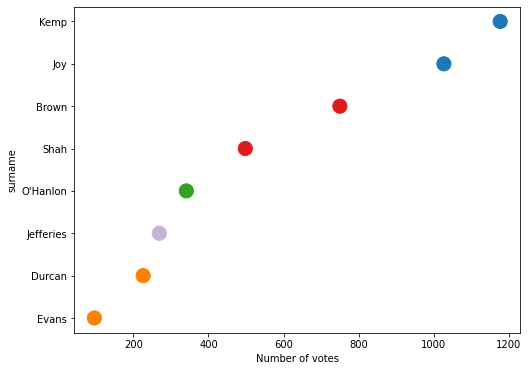

Seats: 3


,Unnamed: 0,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
121,4,Murray,Teresa Margaret,Labour and Co-operative Party,1658,Rochester East and Warren Wood,https://www.medway.gov.uk/info/200670/local_an...,Teresa Margaret,Murray,Labour
118,1,Edwards,Lauren Rae,Labour and Co-operative Party,1517,Rochester East and Warren Wood,https://www.medway.gov.uk/info/200670/local_an...,Lauren Rae,Edwards,Labour
122,5,Osborne,Tristan John,Labour and Co-operative Party,1347,Rochester East and Warren Wood,https://www.medway.gov.uk/info/200670/local_an...,Tristan John,Osborne,Labour
117,0,Clarke,George Harvey Samuel,Local Conservatives,784,Rochester East and Warren Wood,https://www.medway.gov.uk/info/200670/local_an...,George Harvey Samuel,Clarke,Conservative
119,2,Griffin,Sylvia Mary,Local Conservatives,755,Rochester East and Warren Wood,https://www.medway.gov.uk/info/200670/local_an...,Sylvia Mary,Griffin,Conservative
123,6,Sirlan,Tolga,Local Conservatives,665,Rochester East and Warren Wood,https://www.medway.gov.uk/info/200670/local_an...,Tolga,Sirlan,Conservative
124,7,Stone,Marilyn,Green Party,370,Rochester East and Warren Wood,https://www.medway.gov.uk/info/200670/local_an...,Marilyn,Stone,Green Party
120,3,Manuel,Sarah Louise,Liberal Democrats,206,Rochester East and Warren Wood,https://www.medway.gov.uk/info/200670/local_an...,Sarah Louise,Manuel,Liberal Democrats


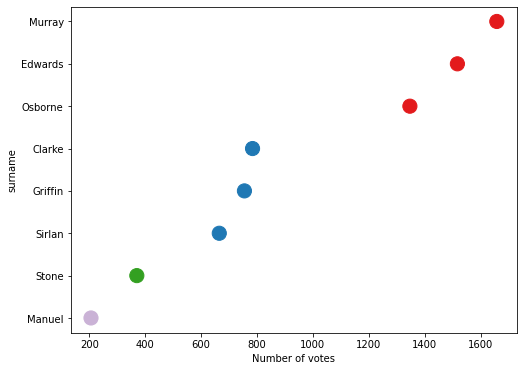

Seats: 3


,Unnamed: 0,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
130,5,Paterson,Alexander John (commonly known as Alex Paterson),Labour and Co-operative Party,1807,Rochester West and Borstal,https://www.medway.gov.uk/info/200670/local_an...,Alex Paterson,Paterson,Labour
125,0,Bowen,Linda Jill,Labour and Co-operative Party,1670,Rochester West and Borstal,https://www.medway.gov.uk/info/200670/local_an...,Linda Jill,Bowen,Labour
126,1,Hamilton,Paula Wilhelmina,Labour and Co-operative Party,1624,Rochester West and Borstal,https://www.medway.gov.uk/info/200670/local_an...,Paula Wilhelmina,Hamilton,Labour
131,6,Tranter,Stuart Albert,Local Conservatives,1336,Rochester West and Borstal,https://www.medway.gov.uk/info/200670/local_an...,Stuart Albert,Tranter,Conservative
129,4,Ohaeri (also known as Rivers),Faith (commonly known as Faith Rivers),Local Conservatives,1080,Rochester West and Borstal,https://www.medway.gov.uk/info/200670/local_an...,Faith Rivers,Ohaeri,Conservative
128,3,Joiner,Timothy Martin (commonly known as Tim Joiner),Local Conservatives,1010,Rochester West and Borstal,https://www.medway.gov.uk/info/200670/local_an...,Tim Joiner,Joiner,Conservative
132,7,Worsley,Stuart Samuel,Green Party,536,Rochester West and Borstal,https://www.medway.gov.uk/info/200670/local_an...,Stuart Samuel,Worsley,Green Party
127,2,Holloway,Anita Jane,Liberal Democrats,303,Rochester West and Borstal,https://www.medway.gov.uk/info/200670/local_an...,Anita Jane,Holloway,Liberal Democrats


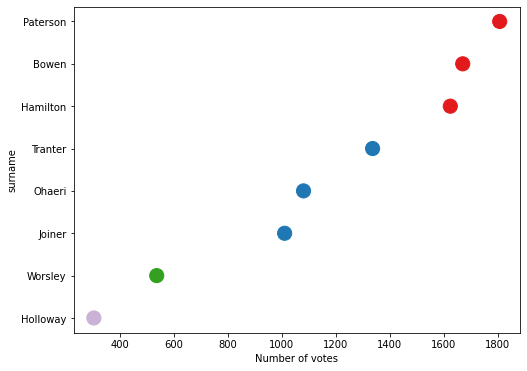

Seats: 1


,Unnamed: 0,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
136,3,Tejan,Habib Odunlamin Sulaiman,Local Conservatives,479,St Mary's Island,https://www.medway.gov.uk/info/200670/local_an...,Habib Odunlamin Sulaiman,Tejan,Conservative
134,1,Castle,John Edward,Liberal Democrats,323,St Mary's Island,https://www.medway.gov.uk/info/200670/local_an...,John Edward,Castle,Liberal Democrats
135,2,Hodges,David Christopher Graham,Labour Party,224,St Mary's Island,https://www.medway.gov.uk/info/200670/local_an...,David Christopher Graham,Hodges,Labour
133,0,Bowes,Caroline Mary,Green Party,47,St Mary's Island,https://www.medway.gov.uk/info/200670/local_an...,Caroline Mary,Bowes,Green Party


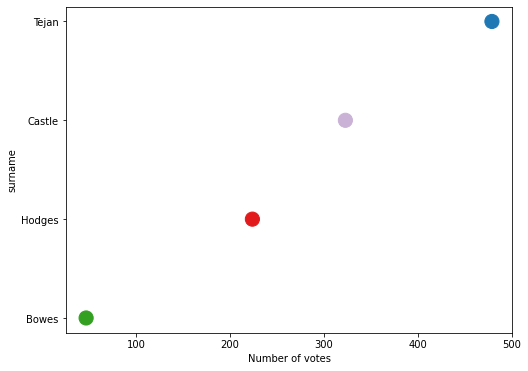

Seats: 3


,Unnamed: 0,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
140,3,Dyke,Zoe Angela Van,Labour and Co-operative Party,1774,Strood North and Frindsbury,https://www.medway.gov.uk/info/200670/local_an...,Zoe Angela Van,Dyke,Labour
143,6,Hubbard,Stephen Alan,Labour and Co-operative Party,1758,Strood North and Frindsbury,https://www.medway.gov.uk/info/200670/local_an...,Stephen Alan,Hubbard,Labour
142,5,Field,David Peter,Labour and Co-operative Party,1682,Strood North and Frindsbury,https://www.medway.gov.uk/info/200670/local_an...,David Peter,Field,Labour
137,0,Batts,Gareth Wilf,Local Conservatives,1202,Strood North and Frindsbury,https://www.medway.gov.uk/info/200670/local_an...,Gareth Wilf,Batts,Conservative
144,7,Liddell,Craig Thomas,Local Conservatives,1078,Strood North and Frindsbury,https://www.medway.gov.uk/info/200670/local_an...,Craig Thomas,Liddell,Conservative
141,4,Edun,Akinola Obafemi (commonly known as Akin Edun),Local Conservatives,1069,Strood North and Frindsbury,https://www.medway.gov.uk/info/200670/local_an...,Akin Edun,Edun,Conservative
145,8,Stephen,Andrew James,Green Party,393,Strood North and Frindsbury,https://www.medway.gov.uk/info/200670/local_an...,Andrew James,Stephen,Green Party
139,2,Clark,Alexander Charles,Liberal Democrats,245,Strood North and Frindsbury,https://www.medway.gov.uk/info/200670/local_an...,Alexander Charles,Clark,Liberal Democrats
138,1,Burch,Peter Richard Ede,Heritage Party,217,Strood North and Frindsbury,https://www.medway.gov.uk/info/200670/local_an...,Peter Richard Ede,Burch,Heritage Party


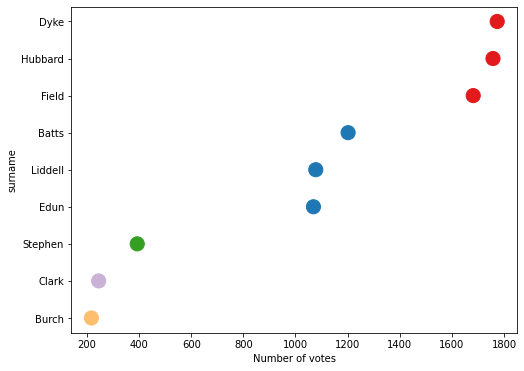

Seats: 3


,Unnamed: 0,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
154,8,Williams,John,Local Conservatives,1458,Strood Rural,https://www.medway.gov.uk/info/200670/local_an...,John,Williams,Conservative
148,2,Etheridge,Gary David James,Local Conservatives,1446,Strood Rural,https://www.medway.gov.uk/info/200670/local_an...,Gary David James,Etheridge,Conservative
152,6,Turpin,Elizabeth Ann,Local Conservatives,1409,Strood Rural,https://www.medway.gov.uk/info/200670/local_an...,Elizabeth Ann,Turpin,Conservative
155,9,Wyatt,Robert Elton,Labour Party,849,Strood Rural,https://www.medway.gov.uk/info/200670/local_an...,Robert Elton,Wyatt,Labour
151,5,Thomas,Elaine Orford,Labour Party,786,Strood Rural,https://www.medway.gov.uk/info/200670/local_an...,Elaine Orford,Thomas,Labour
150,4,Munton,Derek,Labour Party,742,Strood Rural,https://www.medway.gov.uk/info/200670/local_an...,Derek,Munton,Labour
146,0,Atkinson,Neil James,Green Party,379,Strood Rural,https://www.medway.gov.uk/info/200670/local_an...,Neil James,Atkinson,Green Party
147,1,Clark,Joanna Elizabeth,Liberal Democrats,304,Strood Rural,https://www.medway.gov.uk/info/200670/local_an...,Joanna Elizabeth,Clark,Liberal Democrats
149,3,Millsom,Andrew Lawrence,Liberal Democrats,282,Strood Rural,https://www.medway.gov.uk/info/200670/local_an...,Andrew Lawrence,Millsom,Liberal Democrats
153,7,Wells,Alan Edward,Liberal Democrats,219,Strood Rural,https://www.medway.gov.uk/info/200670/local_an...,Alan Edward,Wells,Liberal Democrats


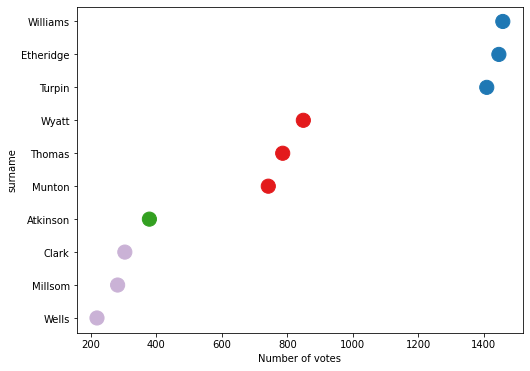

Seats: 3


,Unnamed: 0,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
161,5,Jackson,Sharon Leigh,Labour and Co-operative Party,1338,Strood West,https://www.medway.gov.uk/info/200670/local_an...,Sharon Leigh,Jackson,Labour
162,6,Jones,Mark William,Labour and Co-operative Party,1291,Strood West,https://www.medway.gov.uk/info/200670/local_an...,Mark William,Jones,Labour
163,7,Shokar,Satinder Singh,Labour and Co-operative Party,1236,Strood West,https://www.medway.gov.uk/info/200670/local_an...,Satinder Singh,Shokar,Labour
159,3,Igwe,Ikechukwu (commonly known as Isaac Igwe),Local Conservatives,991,Strood West,https://www.medway.gov.uk/info/200670/local_an...,Isaac Igwe,Igwe,Conservative
160,4,Iles,Josephine Lesley (commonly known as Josie Iles),Local Conservatives,972,Strood West,https://www.medway.gov.uk/info/200670/local_an...,Josie Iles,Iles,Conservative
156,0,Buckwell,Christopher Brian (commonly known as Chris Buc...,Local Conservatives,970,Strood West,https://www.medway.gov.uk/info/200670/local_an...,Chris Buckwell,Buckwell,Conservative
157,1,Griffiths,Susan,Green Party,262,Strood West,https://www.medway.gov.uk/info/200670/local_an...,Susan,Griffiths,Green Party
164,8,Wild,Michael Dennis,Liberal Democrats,159,Strood West,https://www.medway.gov.uk/info/200670/local_an...,Michael Dennis,Wild,Liberal Democrats
158,2,Heathfield,Robert John (commonly known as Rob Heathfield),Independent,155,Strood West,https://www.medway.gov.uk/info/200670/local_an...,Rob Heathfield,Heathfield,Independent


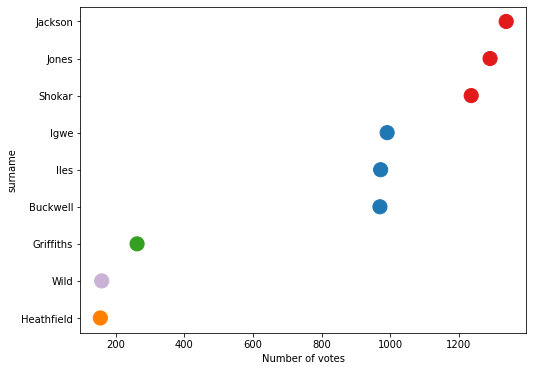

Seats: 2


,Unnamed: 0,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
167,2,Brown,Hazel Louise,Labour and Co-operative Party,967,Twydall,https://www.medway.gov.uk/info/200670/local_an...,Hazel Louise,Brown,Labour
168,3,Prenter,Mark,Labour and Co-operative Party,869,Twydall,https://www.medway.gov.uk/info/200670/local_an...,Mark,Prenter,Labour
166,1,Brewer,Mitchell,Conservative Party candidate,502,Twydall,https://www.medway.gov.uk/info/200670/local_an...,Mitchell,Brewer,Conservative
170,5,Smith,Louise Elizabeth,Conservative Party candidate,489,Twydall,https://www.medway.gov.uk/info/200670/local_an...,Louise Elizabeth,Smith,Conservative
165,0,Belmonte,Catherine Victoria (commonly known as Kate Bel...,Green Party,222,Twydall,https://www.medway.gov.uk/info/200670/local_an...,Kate Belmonte,Belmonte,Green Party
169,4,Ruparel,Maureen,Liberal Democrats,151,Twydall,https://www.medway.gov.uk/info/200670/local_an...,Maureen,Ruparel,Liberal Democrats


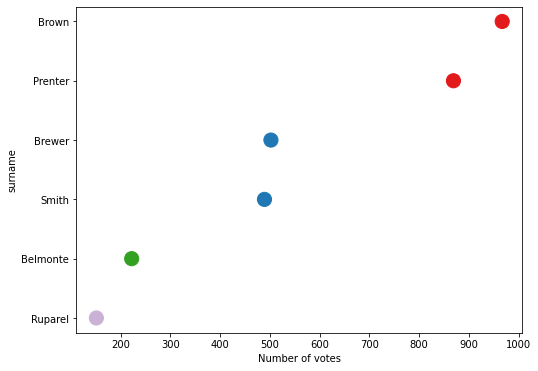

Seats: 3


,Unnamed: 0,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
175,4,Stamp,Christina Melanie (commonly known as Chrissy S...,Labour and Co-operative Party,1998,Watling,https://www.medway.gov.uk/info/200670/local_an...,Chrissy Stamp,Stamp,Labour
171,0,Coombs,Tracy,Labour and Co-operative Party,1977,Watling,https://www.medway.gov.uk/info/200670/local_an...,Tracy,Coombs,Labour
174,3,Nestorov,Marian Angelov,Labour and Co-operative Party,1823,Watling,https://www.medway.gov.uk/info/200670/local_an...,Marian Angelov,Nestorov,Labour
172,1,Marsden,Steven James,Conservative Party candidate,985,Watling,https://www.medway.gov.uk/info/200670/local_an...,Steven James,Marsden,Conservative
177,6,Venus-Coppard,Tina Louise,Conservative Party candidate,817,Watling,https://www.medway.gov.uk/info/200670/local_an...,Tina Louise,Venus-Coppard,Conservative
176,5,Strudwick-Long,Adam,Conservative Party candidate,808,Watling,https://www.medway.gov.uk/info/200670/local_an...,Adam,Strudwick-Long,Conservative
173,2,Munro,Tina,Green Party,361,Watling,https://www.medway.gov.uk/info/200670/local_an...,Tina,Munro,Green Party
178,7,Yale,David William,Liberal Democrats,313,Watling,https://www.medway.gov.uk/info/200670/local_an...,David William,Yale,Liberal Democrats


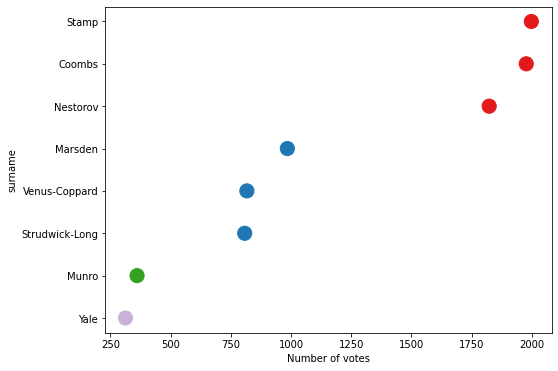

Seats: 2


,Unnamed: 0,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
180,1,Cook,Esther Mary,Labour and Co-operative Party,986,Wayfield and Weeds Wood,https://www.medway.gov.uk/info/200670/local_an...,Esther Mary,Cook,Labour
183,4,Peake,Edmund Ralph Barralet (commonly known as Eddie...,Labour and Co-operative Party,915,Wayfield and Weeds Wood,https://www.medway.gov.uk/info/200670/local_an...,Eddie Peake,Peake,Labour
179,0,Burns,Caroline,Local Conservatives,799,Wayfield and Weeds Wood,https://www.medway.gov.uk/info/200670/local_an...,Caroline,Burns,Conservative
184,5,Rai,Nawal,Local Conservatives,689,Wayfield and Weeds Wood,https://www.medway.gov.uk/info/200670/local_an...,Nawal,Rai,Conservative
182,3,Northwood-Boorman,Judith Elizabeth,Green Party,121,Wayfield and Weeds Wood,https://www.medway.gov.uk/info/200670/local_an...,Judith Elizabeth,Northwood-Boorman,Green Party
181,2,Crack,Herbert John Alfred,Liberal Democrats,108,Wayfield and Weeds Wood,https://www.medway.gov.uk/info/200670/local_an...,Herbert John Alfred,Crack,Liberal Democrats
185,6,Tanner,Steven (commonly known as Steve Tanner),Social Democratic Party,74,Wayfield and Weeds Wood,https://www.medway.gov.uk/info/200670/local_an...,Steve Tanner,Tanner,Social Democratic Party


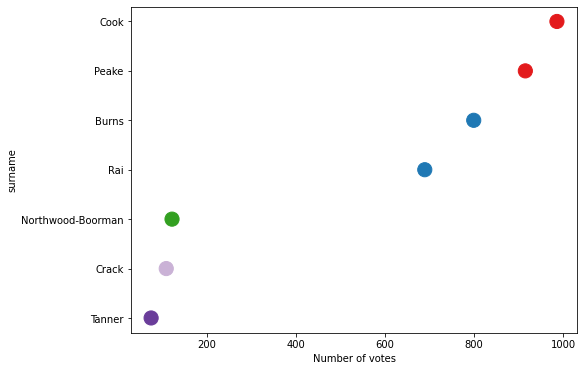

In [11]:
def plot_ward(df):
    (
        df
        .plot(kind='scatter', 
              y='surname', 
              x='Number of votes', 
              figsize=(8,6), 
              s=200,
              c=df['party'].map(map_colors))
    )
    plt.gca().invert_yaxis()
    plt.show()

    return df

for ward in df_results['ward'].unique():
    display(HTML(f'<h3>{ward}</h3>'))
    
    display(HTML(f'<h4>Overview</h4>'))
    print(f'Seats: {ward_seats.get(ward)}')
    
    display(HTML(f'<h4>Candidate results - {ward} - table</h4>'))
    df = df_results[df_results['ward'] == ward].sort_values(by='Number of votes', ascending=False)
    display(df)
    display(HTML(f'<h4>Candidate results - {ward}</h4>'))
    plot_ward(df)
    
    display(HTML(f'<hr/>'))
    
    

In [12]:
df_results[df_results['Surname'] == 'Field']

,Unnamed: 0,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
142,5,Field,David Peter,Labour and Co-operative Party,1682,Strood North and Frindsbury,https://www.medway.gov.uk/info/200670/local_an...,David Peter,Field,Labour


In [13]:
df_results.sort_values(by='Number of votes', ascending=False).head(15)

,Unnamed: 0,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
60,2,Crozer,George Josiah Thomas,Independent,2388,Hoo St Werburgh and High Halstow,https://www.medway.gov.uk/info/200670/local_an...,George Josiah Thomas,Crozer,Independent
64,6,Sands,Ronald Philip (commonly known as Ron Sands),Independent,2279,Hoo St Werburgh and High Halstow,https://www.medway.gov.uk/info/200670/local_an...,Ron Sands,Sands,Independent
63,5,Pearce,Michael Ian,Independent,2230,Hoo St Werburgh and High Halstow,https://www.medway.gov.uk/info/200670/local_an...,Michael Ian,Pearce,Independent
175,4,Stamp,Christina Melanie (commonly known as Chrissy S...,Labour and Co-operative Party,1998,Watling,https://www.medway.gov.uk/info/200670/local_an...,Chrissy Stamp,Stamp,Labour
171,0,Coombs,Tracy,Labour and Co-operative Party,1977,Watling,https://www.medway.gov.uk/info/200670/local_an...,Tracy,Coombs,Labour
174,3,Nestorov,Marian Angelov,Labour and Co-operative Party,1823,Watling,https://www.medway.gov.uk/info/200670/local_an...,Marian Angelov,Nestorov,Labour
130,5,Paterson,Alexander John (commonly known as Alex Paterson),Labour and Co-operative Party,1807,Rochester West and Borstal,https://www.medway.gov.uk/info/200670/local_an...,Alex Paterson,Paterson,Labour
140,3,Dyke,Zoe Angela Van,Labour and Co-operative Party,1774,Strood North and Frindsbury,https://www.medway.gov.uk/info/200670/local_an...,Zoe Angela Van,Dyke,Labour
143,6,Hubbard,Stephen Alan,Labour and Co-operative Party,1758,Strood North and Frindsbury,https://www.medway.gov.uk/info/200670/local_an...,Stephen Alan,Hubbard,Labour
71,1,Brake,David Frederick,Local Conservatives,1752,Lordswood and Walderslade,https://www.medway.gov.uk/info/200670/local_an...,David Frederick,Brake,Conservative


### Which party got the most votes overall?

,Unnamed: 0,Number of votes
party,,
Labour,189,63062
Conservative,212,53841
Independent,29,7921
Green Party,103,7741
Liberal Democrats,102,6978
Heritage Party,1,217
Christian Peoples Alliance,10,208
Reform UK,5,143
Social Democratic Party,13,132


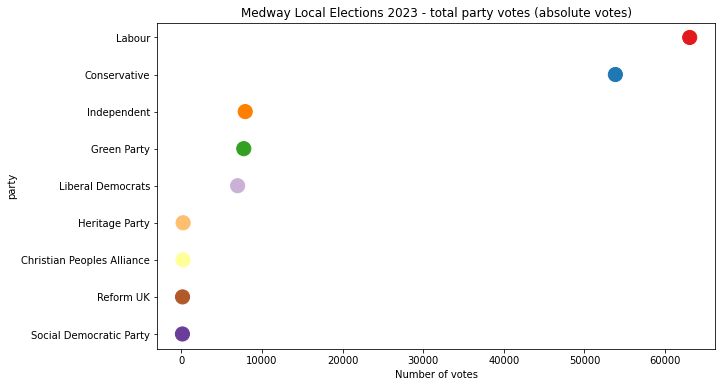

In [14]:


display(df_results.groupby(['party']).sum().sort_values(by='Number of votes', ascending=False))

_df = (
    df_results.groupby(['party']).sum().sort_values(by='Number of votes', ascending=True)
    .reset_index()
)

_df.plot(kind='scatter', x='Number of votes', y='party', 
         s=200,
         c=_df['party'].map(map_colors),
        figsize=(10,6),
        title='Medway Local Elections 2023 - total party votes (absolute votes)')

plt.show()

#### 3.2 Analysis - Wards

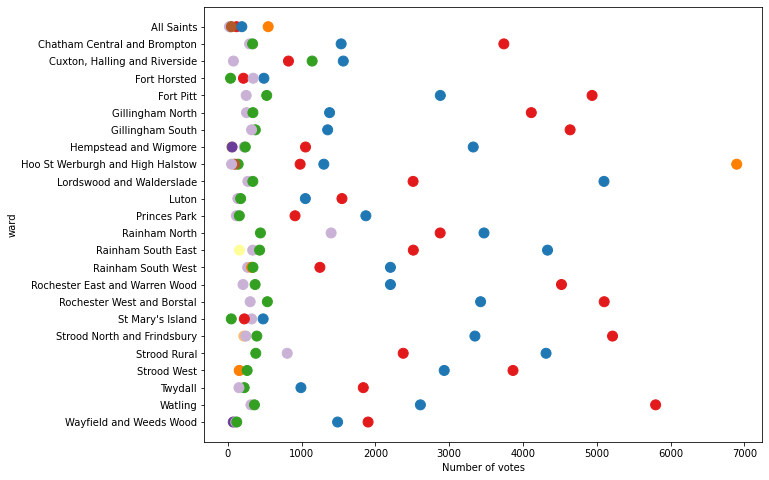

In [15]:
df_results_by_ward = (
    df_results.groupby(['ward', 'party']).sum()
    .reset_index()
    .sort_values(by='ward', ascending=False)
)


df_results_by_ward.plot(kind='scatter', x='Number of votes', y='ward', figsize=(10,8), 
                        s=100,c=df_results_by_ward['party'].map(map_colors))
plt.show()

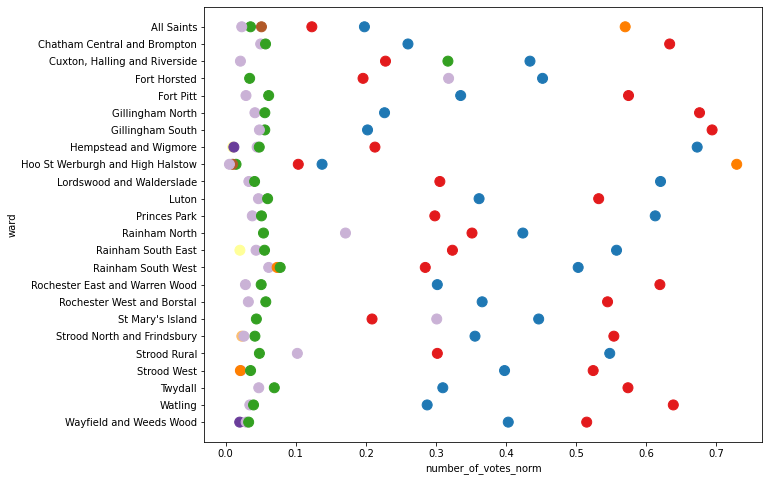

In [16]:
df_results_by_ward = (
    df_results.groupby(['ward', 'party'])['Number of votes'].sum()
    .reset_index()
    .assign(**{'number_of_votes_norm': lambda _df: _df['Number of votes'] / _df.groupby(['ward'])['Number of votes'].transform('sum')})
    .sort_values(by='ward', ascending=False)
)

df_results_by_ward.plot(kind='scatter', x='number_of_votes_norm', y='ward', figsize=(10,8), s=100, c=df_results_by_ward['party'].map(map_colors))
plt.show()

In [17]:
### Top parties in wards
df_results_by_ward.sort_values('number_of_votes_norm', ascending=False).groupby('ward').head(1).sort_values(by=['number_of_votes_norm'], ascending=[True])

,ward,party,Number of votes,number_of_votes_norm
54,Rainham North,Conservative,3472,0.423828
10,"Cuxton, Halling and Riverside",Conservative,1565,0.433999
76,St Mary's Island,Conservative,479,0.446412
14,Fort Horsted,Conservative,489,0.451941
63,Rainham South West,Conservative,2204,0.502737
104,Wayfield and Weeds Wood,Labour,1901,0.514897
92,Strood West,Labour,3865,0.524139
48,Luton,Labour,1547,0.531981
74,Rochester West and Borstal,Labour,5101,0.544630
85,Strood Rural,Conservative,4313,0.547752


### How big is the electorate?

In [18]:
print(f"Electorate: {df_wards['electorate'].sum():,}")

Electorate: 200,668


### Which wards had the best turnout?

In [19]:
(
    df_wards.sort_values('turnout', ascending=False)
    [['ward', 'ballot_papers_verified', 'electorate', 'turnout']]
    .round({'turnout': 2})
)

,ward,ballot_papers_verified,electorate,turnout
16,Rochester West and Borstal,3366,8651,0.39
7,Hempstead and Wigmore,2620,7463,0.35
4,Fort Pitt,3094,9170,0.34
8,Hoo St Werburgh and High Halstow,3349,10049,0.33
17,St Mary's Island,1076,3284,0.33
22,Watling,3304,10149,0.33
14,Rainham South West,2355,7309,0.32
18,Strood North and Frindsbury,3323,10418,0.32
2,"Cuxton, Halling and Riverside",1895,6129,0.31
3,Fort Horsted,1090,3530,0.31


### Which wards mostly use postal votes?

In [20]:
(
    df_wards
    .sort_values(by='postal_ballot_perc', ascending=False)
    [['ward', 'verified_postal_ballot_papers', 'ballot_papers_verified', 'postal_ballot_perc']]
)

,ward,verified_postal_ballot_papers,ballot_papers_verified,postal_ballot_perc
11,Princes Park,813,1621,0.501542
23,Wayfield and Weeds Wood,916,1949,0.469985
1,Chatham Central and Brompton,1007,2201,0.457519
20,Strood West,1214,2656,0.457078
10,Luton,688,1536,0.447917
9,Lordswood and Walderslade,1336,2994,0.446226
21,Twydall,713,1716,0.415501
5,Gillingham North,880,2227,0.395150
12,Rainham North,1144,2971,0.385056
4,Fort Pitt,1190,3094,0.384615


### How many ward seats are there to registered electors?

In [21]:
(
    df_wards
    .assign(**{'ward_seats_per_electorate': lambda _df: _df['electorate'] / _df['ward_seats']})
    .sort_values(by='ward_seats_per_electorate', ascending=False)
    [['ward', 'electorate', 'ward_seats', 'ward_seats_per_electorate']]
    .round({'ward_seats_per_electorate': 1})
)

,ward,electorate,ward_seats,ward_seats_per_electorate
7,Hempstead and Wigmore,7463,2,3731.5
6,Gillingham South,11085,3,3695.0
14,Rainham South West,7309,2,3654.5
9,Lordswood and Walderslade,10857,3,3619.0
23,Wayfield and Weeds Wood,7143,2,3571.5
21,Twydall,7120,2,3560.0
3,Fort Horsted,3530,1,3530.0
1,Chatham Central and Brompton,10525,3,3508.3
0,All Saints,3495,1,3495.0
13,Rainham South East,10466,3,3488.7


### Map ward top party by vote

Which party received the most votes in each ward?

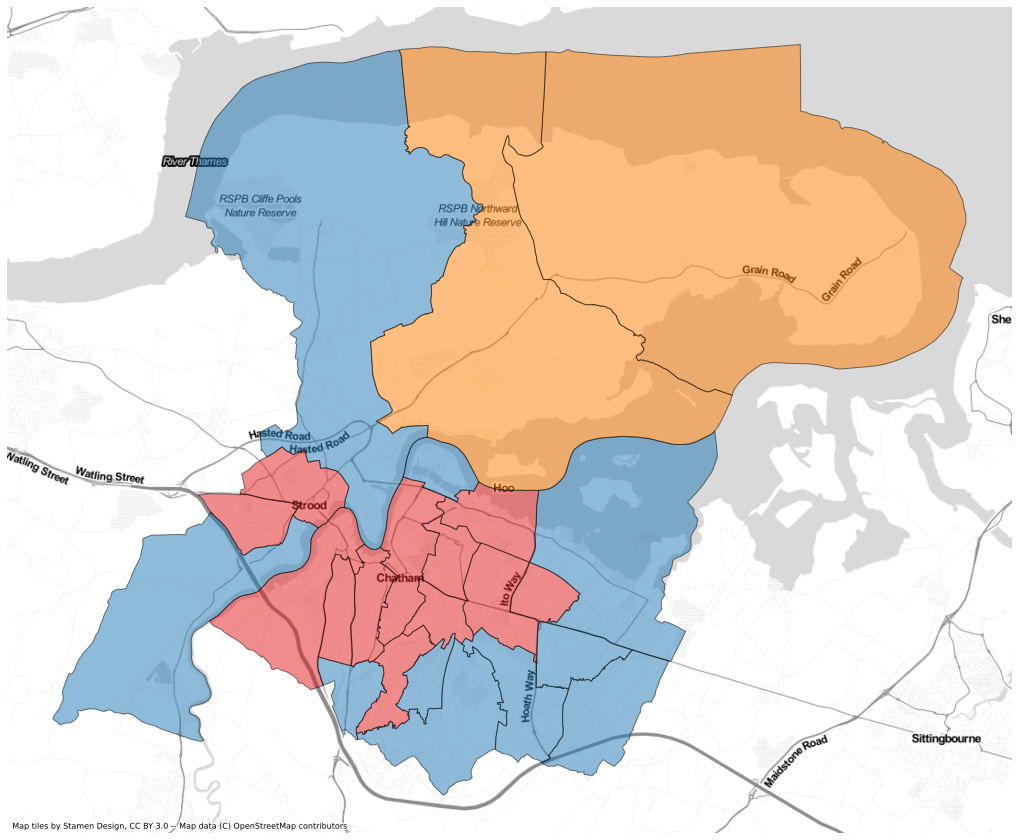

,ward,party,Number of votes,number_of_votes_norm,ward_color
54,Rainham North,Conservative,3472,0.423828,#1f78b4
10,"Cuxton, Halling and Riverside",Conservative,1565,0.433999,#1f78b4
76,St Mary's Island,Conservative,479,0.446412,#1f78b4
14,Fort Horsted,Conservative,489,0.451941,#1f78b4
63,Rainham South West,Conservative,2204,0.502737,#1f78b4
104,Wayfield and Weeds Wood,Labour,1901,0.514897,#e31a1c
92,Strood West,Labour,3865,0.524139,#e31a1c
48,Luton,Labour,1547,0.531981,#e31a1c
74,Rochester West and Borstal,Labour,5101,0.544630,#e31a1c
85,Strood Rural,Conservative,4313,0.547752,#1f78b4


In [22]:
map_ward_names = {
    'Lordswood & Walderslade': 'Lordswood and Walderslade',
    'Hempstead & Wigmore': 'Hempstead and Wigmore',
    'Wayfield & Weeds Wood': 'Wayfield and Weeds Wood',
    'Cuxton, Halling & Riverside': 'Cuxton, Halling and Riverside',
    'Rochester East & Warren Wood': 'Rochester East and Warren Wood',
    'Rochester West & Borstal': 'Rochester West and Borstal',
    'Chatham Central & Brompton': 'Chatham Central and Brompton',
    'Hoo St Werburgh & High Halstow': 'Hoo St Werburgh and High Halstow',
    'Strood North & Frindsbury': 'Strood North and Frindsbury'
}

gpd_medway = (
    gpd.read_file('data/maps/Medway.geojson')
    .drop(columns={'OBJECTID', 'Ward_name'})
    .rename(columns={
        'Name': 'ward_name',
        'No_of_coun': 'councillors',
        'Current_el': 'electorate_current',
        'Forecast_e': 'electorate_forecast'
    })
    .assign(**{
        'ward_name': lambda x: x['ward_name'].replace(to_replace=map_ward_names),
    })
)


df_ward_top_party = (
    df_results_by_ward
    .sort_values('number_of_votes_norm', ascending=False)
    .groupby('ward').head(1).
    sort_values(by=['number_of_votes_norm'], ascending=[True])
    .assign(**{'ward_color': lambda x: x['party'].replace(map_colors)})
)


gdp_medway_top_party = (
    gpd_medway
    .merge(
        df_ward_top_party,
        left_on='ward_name',
        right_on='ward', how='left')
).to_crs(epsg=3857)

ax = gdp_medway_top_party.plot(figsize=(18,20), color=gdp_medway_top_party['ward_color'], edgecolor="black", alpha=0.5)
cx.add_basemap(ax,crs=gdp_medway_top_party.crs, source=cx.providers.Stamen.TonerLite)
# cx.add_basemap(ax,crs=gdp_medway_top_party.crs, source=cx.providers.Stamen.TonerLabels, zoom=12)

# gdp_medway_top_party
plt.axis('off')
plt.show()

display(df_ward_top_party)

### Voter turnout choropleth


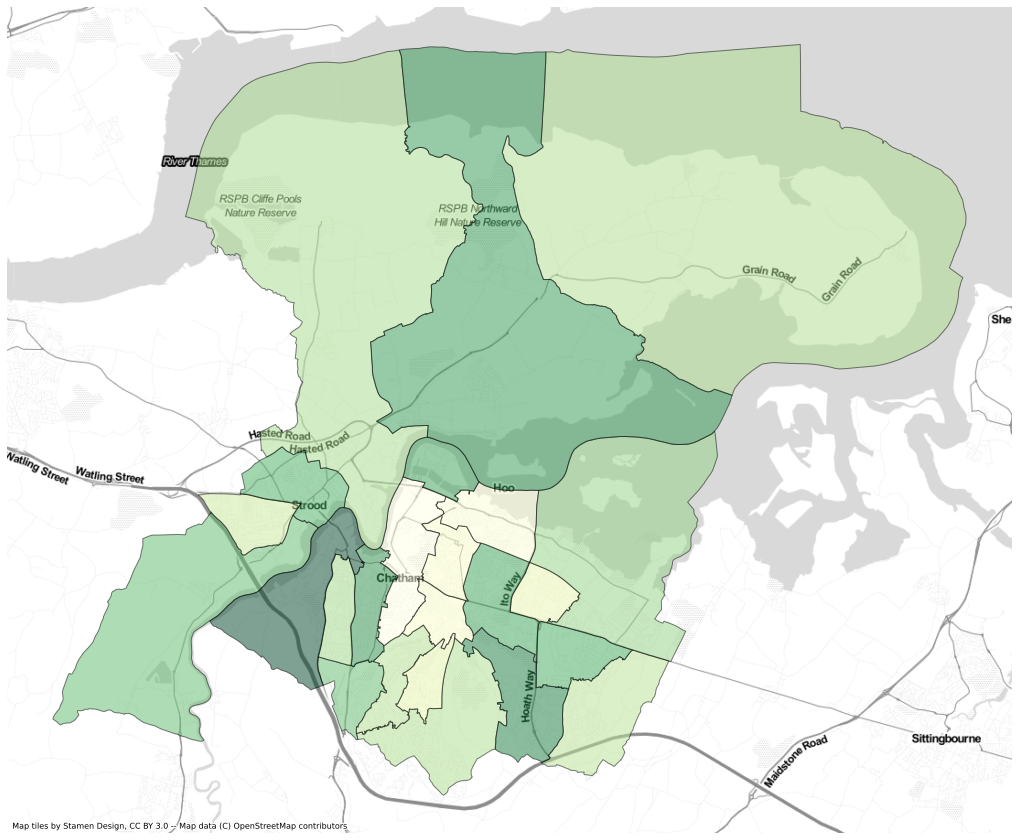

,ward,turnout
0,Fort Horsted,0.308782
1,Rainham South East,0.271546
2,Lordswood and Walderslade,0.275767
3,Princes Park,0.243943
4,Hempstead and Wigmore,0.351065
5,Wayfield and Weeds Wood,0.272855
6,Rainham South West,0.322206
7,Luton,0.223548
8,Twydall,0.241011
9,Rochester East and Warren Wood,0.281534


In [23]:
gdp_medway_wards = (
    gpd_medway
    .merge(
        df_wards,
        left_on='ward_name',
        right_on='ward', how='left')
).to_crs(epsg=3857)

ax = gdp_medway_wards.plot(figsize=(18,20), column='turnout', edgecolor="black", alpha=0.5, cmap='YlGn')
cx.add_basemap(ax,crs=gdp_medway_wards.crs, source=cx.providers.Stamen.TonerLite)

plt.axis('off')
plt.show()

display(gdp_medway_wards[['ward', 'turnout']])

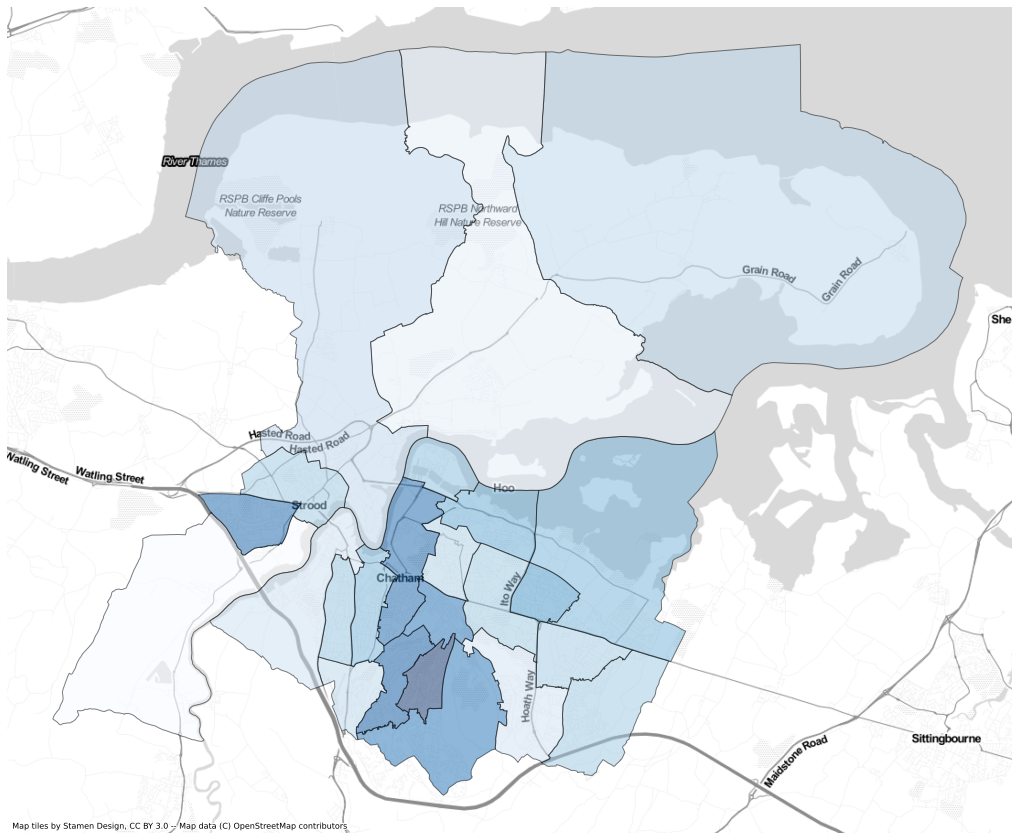

,ward,postal_ballot_perc
3,Princes Park,0.501542
5,Wayfield and Weeds Wood,0.469985
17,Chatham Central and Brompton,0.457519
15,Strood West,0.457078
7,Luton,0.447917
2,Lordswood and Walderslade,0.446226
8,Twydall,0.415501
16,Gillingham North,0.395150
20,Rainham North,0.385056
10,Fort Pitt,0.384615


In [24]:
gdp_medway_wards = (
    gpd_medway
    .merge(
        df_wards,
        left_on='ward_name',
        right_on='ward', how='left')
).to_crs(epsg=3857)

ax = gdp_medway_wards.plot(figsize=(18,20), column='postal_ballot_perc', edgecolor="black", alpha=0.5, cmap='Blues')
cx.add_basemap(ax,crs=gdp_medway_wards.crs, source=cx.providers.Stamen.TonerLite)

plt.axis('off')
plt.show()

display(gdp_medway_wards[['ward', 'postal_ballot_perc']].sort_values(by='postal_ballot_perc', ascending=False))